In [1]:
!pip install numpy scipy matplotlib

# Phase 1

In [3]:
import scipy.io
import os

# Load the .mat file
file_path = os.path.join('MAT', 'G_S0023_M1_E1_R4_N1_raw_ref.mat')
mat_data = scipy.io.loadmat(file_path)

# Show all keys in the file
print("Keys in .mat file:", mat_data.keys())


Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'Data'])


In [4]:
eeg_signal = mat_data['Data']  # Replace 'eeg' with your actual key
print("EEG shape:", eeg_signal.shape)


EEG shape: (6, 8000)


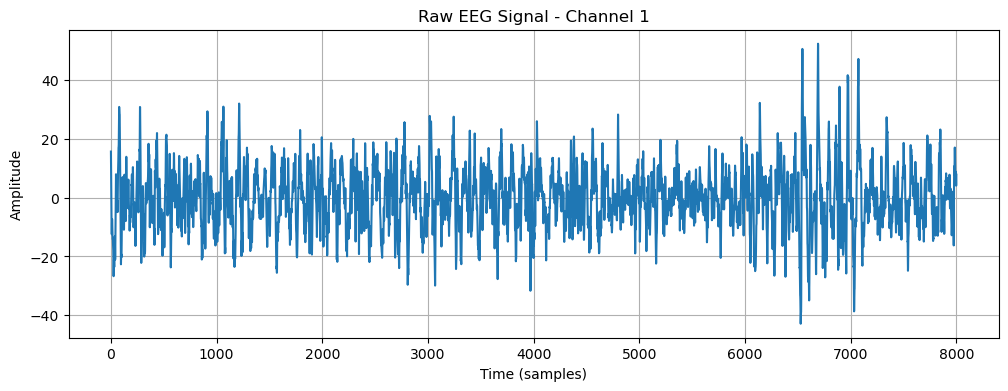

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(eeg_signal[0])  # First channel
plt.title("Raw EEG Signal - Channel 1")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [20]:
with open('data/eeg_summary.txt', 'w') as f:
    f.write(f"EEG shape: {eeg_signal.shape}\n")
    f.write("Channels: {}\n".format(eeg_signal.shape[0]))
    f.write("Timepoints: {}\n".format(eeg_signal.shape[1]))

print("Summary saved to data/eeg_summary1.txt")

Summary saved to data/eeg_summary1.txt


# Phase 2

In [12]:
import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import os

In [13]:
# Load your EEG file
mat_data = scipy.io.loadmat('G_S0023_M1_E1_R4_N1_raw_ref.mat')

# Replace 'eeg' with the actual key from your file
eeg_signal = mat_data['Data']  # Shape: (channels, timepoints)
print("EEG shape:", eeg_signal.shape)

EEG shape: (6, 8000)


In [14]:
def bandpass_filter(data, lowcut=1, highcut=45, fs=200, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply filter to each channel
fs = 200  # Sampling rate
filtered_eeg = np.array([bandpass_filter(channel, fs=fs) for channel in eeg_signal])
print("Filtered EEG shape:", filtered_eeg.shape)

Filtered EEG shape: (6, 8000)


In [15]:
segment_length = 2 * fs  # 400 samples
total_length = filtered_eeg.shape[1]

segments = []
for start in range(0, total_length - segment_length + 1, segment_length):
    end = start + segment_length
    segment = filtered_eeg[:, start:end]
    segments.append(segment)

segments = np.array(segments)  # Shape: (num_segments, channels, segment_length)
print("Segmented EEG shape:", segments.shape)

Segmented EEG shape: (20, 6, 400)


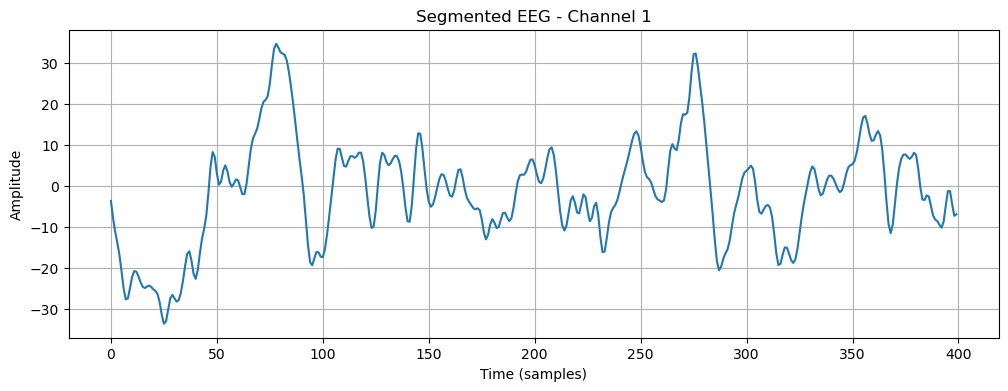

In [16]:
# Plot first channel of the first segment
plt.figure(figsize=(12, 4))
plt.plot(segments[0][0])  # First segment, first channel
plt.title("Segmented EEG - Channel 1")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [24]:
np.save('data/subject02_segments.npy', segments)
print("Segments saved to data/subject02_segments.npy")

Segments saved to data/subject02_segments.npy


# Phase 3

In [25]:
import numpy as np

# Load the segments saved in Phase 2
segments = np.load('data/subject02_segments.npy')
print("Segments shape:", segments.shape)  # (num_segments, channels, segment_length)

Segments shape: (20, 6, 400)


In [26]:
from scipy.signal import welch

# Define frequency bands
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

def extract_psd_features(segment, fs=200):
    features = []
    for channel in segment:
        freqs, psd = welch(channel, fs=fs)
        for band in bands.values():
            idx = np.logical_and(freqs >= band[0], freqs <= band[1])
            band_power = np.sum(psd[idx])
            features.append(band_power)
    return features

# Apply to all segments
psd_features = [extract_psd_features(seg) for seg in segments]
psd_features = np.array(psd_features)
print("PSD Features shape:", psd_features.shape)


PSD Features shape: (20, 30)


In [27]:
import pywt

def extract_dwt_features(segment, wavelet='db4', level=4):
    features = []
    for channel in segment:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        for c in coeffs:
            features.extend([
                np.mean(c),
                np.std(c),
                np.max(c),
                np.min(c)
            ])
    return features

# Apply to all segments
dwt_features = [extract_dwt_features(seg) for seg in segments]
dwt_features = np.array(dwt_features)
print("DWT Features shape:", dwt_features.shape)


DWT Features shape: (20, 120)


In [29]:
# Combine PSD and DWT features
combined_features = np.hstack((psd_features, dwt_features))
print("Combined Features shape:", combined_features.shape)

# Save for future use
np.save('data/subject02_features.npy', combined_features)
print("Features saved to data/subject02_features.npy")


Combined Features shape: (20, 150)
Features saved to data/subject02_features.npy


# Phase 4

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [31]:
# Load features saved in Phase 3
features = np.load('data/subject01_features.npy')
print("Features shape:", features.shape)  # (num_segments, num_features)

Features shape: (20, 150)


In [32]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [33]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

print("Explained variance:", pca.explained_variance_ratio_)

Explained variance: [0.27485469 0.1071727 ]


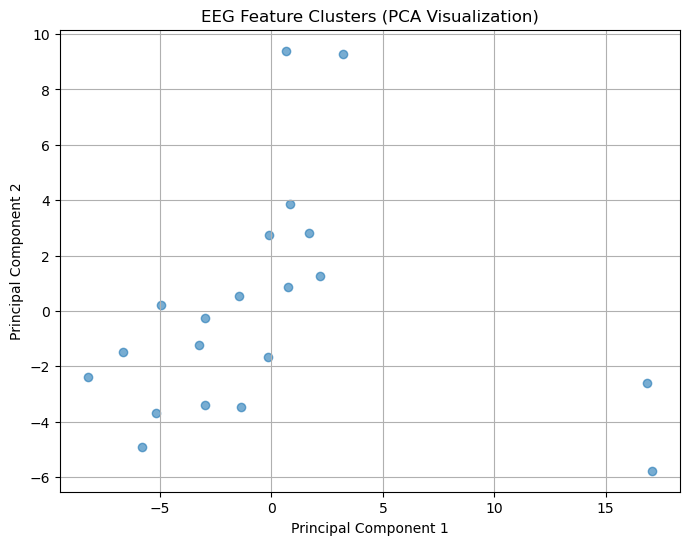

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.6)
plt.title("EEG Feature Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [35]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

print("Cluster labels:", cluster_labels[:10])

Cluster labels: [0 0 0 1 1 0 0 1 1 0]


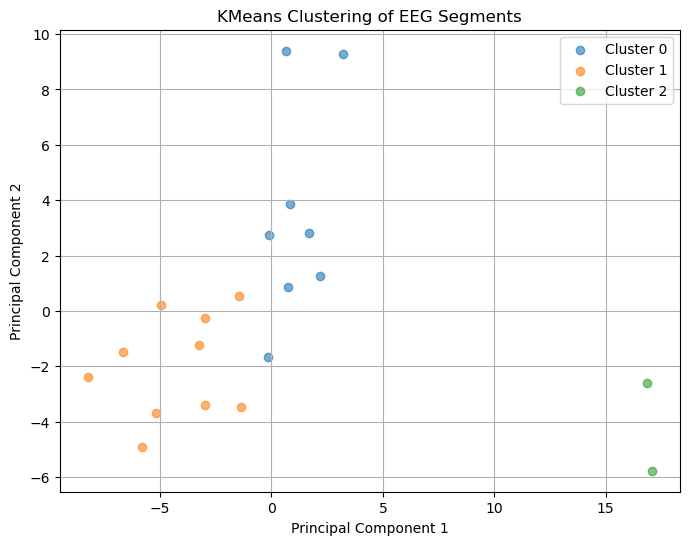

In [36]:
plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    idx = cluster_labels == cluster
    plt.scatter(features_pca[idx, 0], features_pca[idx, 1], label=f"Cluster {cluster}", alpha=0.6)

plt.title("KMeans Clustering of EEG Segments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
np.save('data/subject02_clusters.npy', cluster_labels)
print("Cluster labels saved to data/subject02_clusters.npy")


Cluster labels saved to data/subject02_clusters.npy


# Phase 5

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [39]:
features = np.load('data/subject01_features.npy')
print("Features shape:", features.shape)

Features shape: (20, 150)


In [40]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [41]:
scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")


Clusters: 2, Silhouette Score: 0.3298
Clusters: 3, Silhouette Score: 0.1175
Clusters: 4, Silhouette Score: 0.1075
Clusters: 5, Silhouette Score: 0.1022
Clusters: 6, Silhouette Score: 0.0910
Clusters: 7, Silhouette Score: 0.1026
Clusters: 8, Silhouette Score: 0.0560
Clusters: 9, Silhouette Score: 0.0672


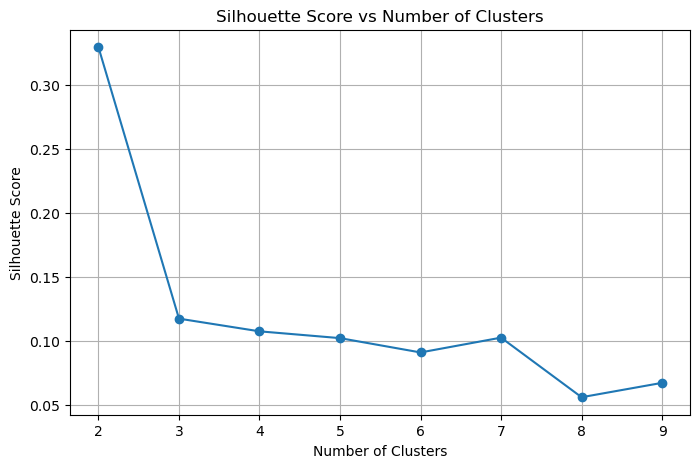

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [43]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

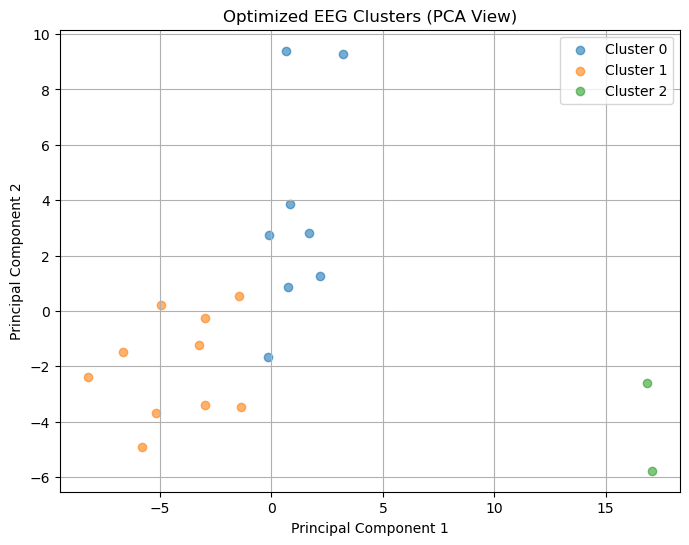

In [44]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    idx = cluster_labels == cluster
    plt.scatter(features_pca[idx, 0], features_pca[idx, 1], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Optimized EEG Clusters (PCA View)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
np.save('data/subject02_optimized_clusters.npy', cluster_labels)
print("Optimized cluster labels saved.")

Optimized cluster labels saved.


# Phase 6

In [3]:
import numpy as np

# Load features and cluster labels
features = np.load('data/subject02_features.npy')
clusters = np.load('data/subject02_optimized_clusters.npy')

print("Features shape:", features.shape)
print("Cluster labels shape:", clusters.shape)

Features shape: (20, 150)
Cluster labels shape: (20,)


In [4]:
import pandas as pd

# Combine features and cluster labels
summary_df = pd.DataFrame(features)
summary_df['Cluster'] = clusters

# Show basic stats
print("Cluster counts:")
print(summary_df['Cluster'].value_counts())

# Save summary
summary_df.to_csv('results/subject02_cluster_summary.csv', index=False)
print("Summary saved to results/subject02_cluster_summary.csv")


Cluster counts:
1    10
0     8
2     2
Name: Cluster, dtype: int64
Summary saved to results/subject02_cluster_summary.csv


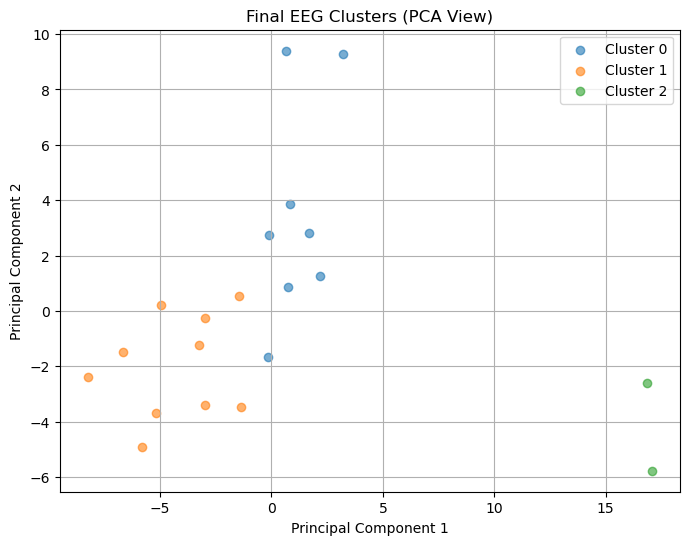

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize and reduce to 2D
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Plot and save
plt.figure(figsize=(8, 6))
for cluster in np.unique(clusters):
    idx = clusters == cluster
    plt.scatter(features_pca[idx, 0], features_pca[idx, 1], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Final EEG Clusters (PCA View)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.savefig('results/final_clusters_plot1.png')
plt.show()

In [51]:
import numpy as np

# Load cluster labels (from Phase 5)
clusters = np.load('data/subject02_optimized_clusters.npy')

In [52]:
unique, counts = np.unique(clusters, return_counts=True)
emotion_summary = dict(zip(unique, counts))
print("Segment counts per cluster:", emotion_summary)

Segment counts per cluster: {0: 8, 1: 10, 2: 2}


In [55]:
cluster_emotions = {
    0: "Calm",
    1: "Anxious",
    2: "Vivid/Excited"
}



In [56]:
summary_lines = []
total_segments = len(clusters)

summary_lines.append("🛌 Dream Emotion Summary:")
summary_lines.append(f"Total EEG segments analyzed: {total_segments}\n")

for cluster_id, count in emotion_summary.items():
    emotion = cluster_emotions.get(cluster_id, "Unknown")
    percentage = (count / total_segments) * 100
    summary_lines.append(f"- {emotion} ({cluster_id}): {count} segments ({percentage:.1f}%)")

# Print the summary
print("\n".join(summary_lines))

🛌 Dream Emotion Summary:
Total EEG segments analyzed: 20

- Calm (0): 8 segments (40.0%)
- Anxious (1): 10 segments (50.0%)
- Vivid/Excited (2): 2 segments (10.0%)


In [57]:
!pip install matplotlib


In [58]:
%matplotlib inline

In [63]:
import numpy as np

# Load your cluster labels
clusters = np.load('data/subject02_optimized_clusters.npy')
print("Total segments:", len(clusters))
print("First 10 cluster labels:", clusters[:10])

Total segments: 20
First 10 cluster labels: [0 0 0 1 1 0 0 1 1 0]


In [64]:
# Define your emotion mapping
emotion_map = {
    0: "Calm",
    1: "Anxious",
    2: "Vivid/Excited"
}

In [65]:
# Count segments per cluster
unique, counts = np.unique(clusters, return_counts=True)
total = len(clusters)

# Print summary
print("🛌 Dream Emotion Summary:")
for cluster_id, count in zip(unique, counts):
    emotion = emotion_map.get(cluster_id, f"Cluster {cluster_id}")
    percentage = (count / total) * 100
    print(f"- {emotion}: {count} segments ({percentage:.1f}%)")

🛌 Dream Emotion Summary:
- Calm: 8 segments (40.0%)
- Anxious: 10 segments (50.0%)
- Vivid/Excited: 2 segments (10.0%)


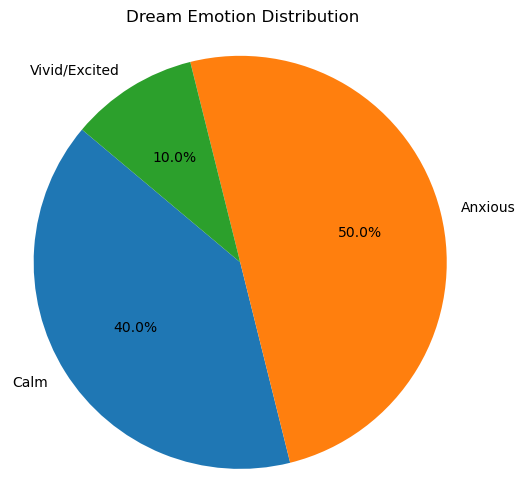

In [66]:
import matplotlib.pyplot as plt

labels = [emotion_map.get(cid, f"Cluster {cid}") for cid in unique]
sizes = [(count / total) * 100 for count in counts]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Dream Emotion Distribution")
plt.axis('equal')
plt.show()


# Final summarization

In [1]:
import numpy as np
import random

def generate_clean_unique_summary(cluster_file, emotion_map):
    clusters = np.load(cluster_file)
    total_segments = len(clusters)

    # Count segments per cluster
    unique, counts = np.unique(clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))

    # Detect transitions
    transitions = np.sum(clusters[:-1] != clusters[1:])
    transition_rate = transitions / total_segments

    # Dominant emotion
    dominant_cluster = max(cluster_counts, key=cluster_counts.get)
    dominant_emotion = emotion_map.get(dominant_cluster, f"Cluster {dominant_cluster}")

    # Emotion diversity
    emotion_palette = [emotion_map.get(cid, f"Cluster {cid}") for cid in cluster_counts.keys()]
    emotion_palette = list(set(emotion_palette))

    # Dynamic sentence templates
    opening_lines = [
        "The dream began quietly, like a whisper in the dark.",
        "Sleep unfolded like a slow tide, pulling the mind into hidden places.",
        "The night opened its arms, and the dream stepped gently into its embrace."
    ]

    dominant_lines = [
        f"Most of the journey was colored by {dominant_emotion.lower()}, shaping the dream's tone with subtle depth.",
        f"{dominant_emotion} lingered throughout, like a familiar melody echoing in the background.",
        f"The dream seemed to rest in the arms of {dominant_emotion.lower()}, steady and unshaken."
    ]

    transition_lines = [
        "But the mind wandered — shifting, stirring, never quite still.",
        "Yet emotions danced and changed, like shadows flickering across a wall.",
        "Still, the dream was not one note — it moved, it morphed, it whispered new feelings."
    ]

    closing_lines = [
        "By morning, the dream had faded, but its rhythm remained — a quiet echo in the sleeper's soul.",
        "And when the eyes opened, the dream dissolved, leaving behind only a trace of its emotional trail.",
        "The dream ended not with a scene, but with a feeling — something unspoken, yet deeply felt."
    ]

    # Build summary
    summary = ""
    summary += random.choice(opening_lines) + "\n\n"
    summary += random.choice(dominant_lines) + "\n"

    if transition_rate > 0.3 and len(emotion_palette) > 1:
        summary += random.choice(transition_lines) + "\n"

    summary += "\n" + random.choice(closing_lines)

    return summary

In [3]:
emotion_map = {
    0: "Calm",
    1: "Anxious",
    2: "Vivid",
    3: "Melancholic",
    4: "Euphoric"
}

summary = generate_clean_unique_summary('data/subject02_optimized_clusters.npy', emotion_map)
print(summary)

The dream began quietly, like a whisper in the dark.

Anxious lingered throughout, like a familiar melody echoing in the background.
Still, the dream was not one note — it moved, it morphed, it whispered new feelings.

By morning, the dream had faded, but its rhythm remained — a quiet echo in the sleeper's soul.


In [4]:
with open('results/dream_emotion_summary02.txt', 'w') as f:
    f.write(summary)

print("Summary saved successfully.")


Summary saved successfully.
